<a href="https://colab.research.google.com/github/UkeshThapa/Snowmelt-Driven-Streamflow-Prediction/blob/main/snow_melting_research_work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Snow Melting Prediction With LSTM, TCN and Transformer**

## install required library

In [5]:
# !pip install -U keras-tuner
# !pip install keras==2.12.0
# !pip install keras-tcn

## import Library

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# normalize the data
from sklearn.preprocessing import StandardScaler

# model library
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import SGD,RMSprop,Adam,Adadelta,Adagrad,Adamax,Nadam

# hyperparameter tuner
import keras_tuner as kt

# loss
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


## Load Dataset

In [9]:

# Load your dataset

def load_dataset(path):
    return pd.read_csv(path)


file_path = "/content/drive/MyDrive/Colab Notebooks/dataset/bigdata.csv"
df_snow_melting = load_dataset(file_path)

df_snow_melting


,Date,Q,SCA,T,P,Day,Relative Humidity,Wind speed,Wind direction,Snow depth
0,1/1/2001,2.69,345.815123,-4.169740,0.000000,1,60.49,3.18,220.08,0.000170
1,1/2/2001,2.53,343.608727,-4.142604,0.000000,2,53.93,1.86,210.97,0.000133
2,1/3/2001,2.53,341.437417,-5.148725,0.000000,3,42.20,1.49,239.45,0.000128
3,1/4/2001,2.43,339.336277,-6.523695,0.031144,4,40.48,1.91,249.20,0.000122
4,1/5/2001,2.53,337.340394,-6.860106,0.000000,5,27.34,2.14,334.61,0.000116
...,...,...,...,...,...,...,...,...,...,...
4012,12/26/2012,2.91,228.615063,-5.651230,0.000000,361,46.49,1.43,257.42,0.000466
4013,12/27/2012,2.91,219.264614,-5.501225,0.000000,362,43.99,2.98,246.87,0.000437
4014,12/28/2012,3.03,210.043412,-5.526874,0.000000,363,27.19,2.54,263.59,0.000410
4015,12/29/2012,2.97,201.080703,-5.107484,0.000000,364,33.50,3.10,256.97,0.000379


## Dataset Pre-processing

In [10]:
df_snow_melting = df_snow_melting[['Date',"Q","SCA","T"]]

In [11]:
import datetime

def str_to_datetime(s):
    split = s.split('/')
    month,day,year = int(split[0]),int(split[1]),int(split[2])

    return datetime.datetime(year=year,month=month,day=day)


In [12]:
df_snow_melting['Date'] = df_snow_melting['Date'].apply(str_to_datetime)

<ipython-input-12-feeee52291b4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_snow_melting['Date'] = df_snow_melting['Date'].apply(str_to_datetime)


## Data visualization in time series

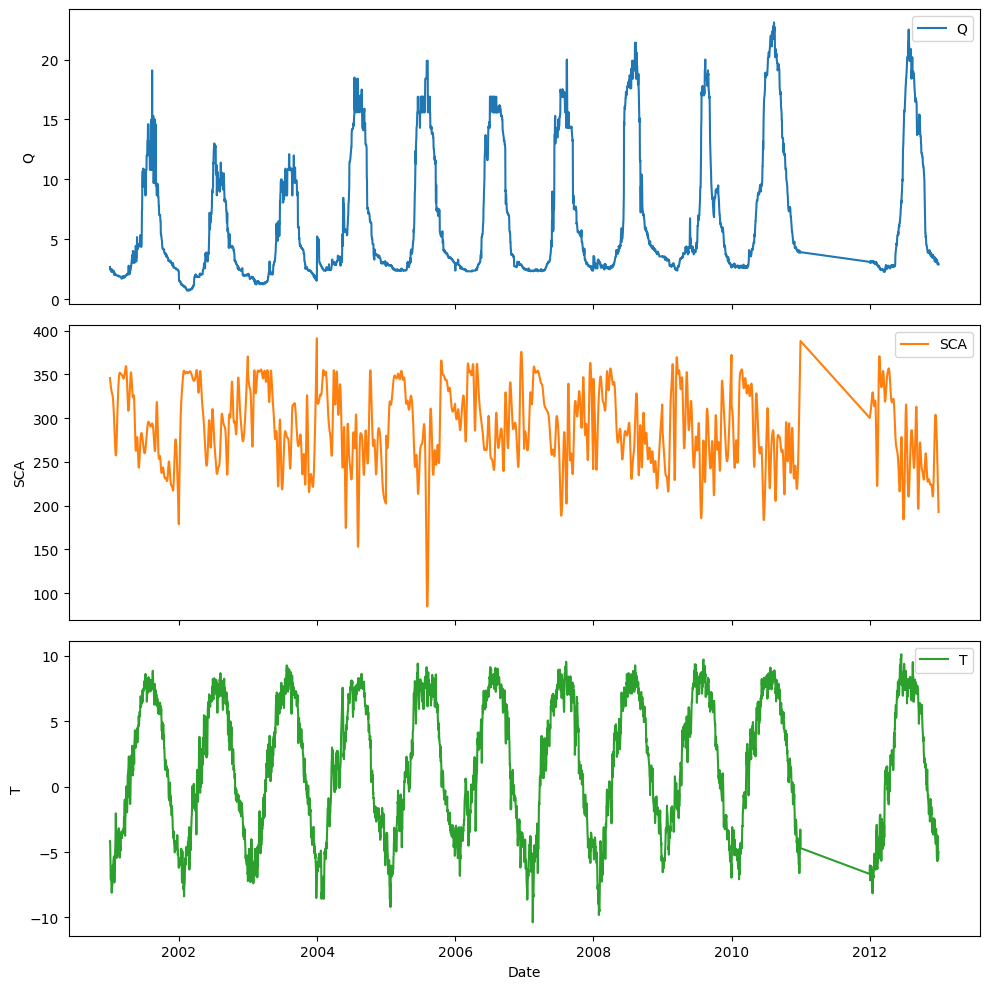

In [13]:
columns_to_plot = ['Q', 'SCA', 'T']

# Create subplots for each column
fig, axes = plt.subplots(len(columns_to_plot), 1, figsize=(10, 10), sharex=True)

for i, column in enumerate(columns_to_plot):
    axes[i].plot(df_snow_melting['Date'], df_snow_melting[column], label=column, color='C'+str(i))
    axes[i].set_ylabel(column)
    axes[i].legend()

# Set common x-label
axes[-1].set_xlabel('Date')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


## Data Normalization

In [14]:

# Initialize the MinMaxScaler
scaler = StandardScaler()

# Define the columns to be scaled (excluding the 'Date' column)
columns_to_scale = ['SCA', 'T']

# test

df_snow_melting[columns_to_scale] = scaler.fit_transform(df_snow_melting[columns_to_scale])
df_snow_melting



<ipython-input-14-c8bb3bd7978b>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_snow_melting[columns_to_scale] = scaler.fit_transform(df_snow_melting[columns_to_scale])


,Date,Q,SCA,T
0,2001-01-01,2.69,1.306925,-1.170123
1,2001-01-02,2.53,1.255788,-1.164703
2,2001-01-03,2.53,1.205464,-1.365690
3,2001-01-04,2.43,1.156767,-1.640360
4,2001-01-05,2.53,1.110509,-1.707563
...,...,...,...,...
4012,2012-12-26,2.91,-1.409374,-1.466072
4013,2012-12-27,2.91,-1.626085,-1.436107
4014,2012-12-28,3.03,-1.839801,-1.441230
4015,2012-12-29,2.97,-2.047526,-1.357451


In [15]:
# Define the feature columns (X) and target column (y)
feature_columns = ['SCA', 'T']
target_column = 'Q'

X, y = df_snow_melting[feature_columns], df_snow_melting[target_column]

X,y = X.values,y.values


# Split dataset as train test and val


In [16]:

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)  # 80% training

# Further split the remaining data into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # 10% validation, 10% testing


In [17]:
#  reshape the data to fit in model for Lstm (3D array)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


In [18]:
print("Train shape",X_train.shape)
print("val shape",X_val.shape)
print("Test shape",X_test.shape)

Train shape (3213, 2, 1)
val shape (402, 2, 1)
Test shape (402, 2, 1)


# LSTM (Long Short Term Memory)

## Create model

In [27]:

model = Sequential()
model.add(LSTM(32, activation='relu', return_sequences=False, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.1))
model.add(Dense(1, activation='linear'))

optimizer = Adamax(learning_rate=0.01,beta_1=0.9, beta_2=0.999)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae', 'mse',])

model.summary()

In [26]:

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32)


# Hyperparameter Tuning

# find optimizers

In [33]:
def build_model(hp):
    model = Sequential()
    model.add(LSTM(32, activation='relu', return_sequences=False, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='linear'))

    optimizer = hp.Choice('optimizer', values = ["sgd","rmsprop","adam","adadelta","adagrad","adamax","adam"])
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae', 'mse',])

    return model


In [53]:
from sklearn.utils import validation
tuner  = kt.RandomSearch(build_model,
                         objective='val_loss',
                         max_trials=10)

tuner.search(X_train,y_train,epochs=5,validation_data=(X_val,y_val))

Trial 6 Complete [00h 00m 05s]
val_loss: 67.3488540649414

Best val_loss So Far: 7.22945499420166
Total elapsed time: 00h 00m 30s


In [54]:
tuner.get_best_hyperparameters()[0].values


{'optimizer': 'sgd'}

In [94]:
!rm -r /content/untitled_project

## Number of hidden units

In [77]:
def build_model(hp):
    model = Sequential()

    units = hp.Int('units',min_value = 1,max_value = 128,step=5)

    model.add(LSTM(units=units, activation='relu', return_sequences=False, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='linear'))
    optimizer = hp.Choice('optimizer', values = ["sgd","rmsprop","adam","adadelta","adagrad","adamax","adam"])
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae', 'mse',])

    return model



In [78]:
from sklearn.utils import validation
tuner  = kt.RandomSearch(build_model,
                         objective='val_mae',
                         max_trials=100)

tuner.search(X_train,y_train,epochs=5,validation_data=(X_val,y_val))

Trial 100 Complete [00h 00m 05s]
val_mae: 6.208195686340332

Best val_mae So Far: 1.8050360679626465
Total elapsed time: 00h 09m 47s


In [79]:
tuner.get_best_hyperparameters()[0].values

{'units': 36, 'optimizer': 'sgd'}

In [81]:
model = tuner.get_best_models(num_models=1)[0]
print(model.summary())
model.fit(X_train,y_train,batch_size=32,epochs=100,validation_data=(X_val,y_val))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 36)                5472      
                                                                 
 dropout (Dropout)           (None, 36)                0         
                                                                 
 dense (Dense)               (None, 1)                 37        
                                                                 
Total params: 5509 (21.52 KB)
Trainable params: 5509 (21.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/100
101/101 [==============================] - 2s 7ms/step - loss: 9.0709 - mae: 2.0290 - mse: 9.0709 - val_loss: 7.1922 - val_mae: 1.8182 - val_mse: 7.1922
Epoch 2/100
101/101 [==============================] - 0s 4ms/step - loss: 8.8137 - mae: 2.0119 - mse: 8.8137 - val_

# learning rate

In [86]:
def build_model(hp):
    model = Sequential()

    model.add(LSTM(36, activation='relu', return_sequences=False, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='linear'))
    optimizer = SGD(learning_rate=hp.Float(name='lr', min_value=0.005, max_value=0.05, step=0.005),momentum=hp.Float(name='mom', min_value=0.0, max_value=0.9, step=0.1))
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae', 'mse',])

    return model



In [87]:
from sklearn.utils import validation
tuner  = kt.RandomSearch(build_model,
                         objective='val_mae',
                         max_trials=100)

tuner.search(X_train,y_train,epochs=5,validation_data=(X_val,y_val))

Trial 89 Complete [00h 00m 05s]
val_mae: 1.743226170539856

Best val_mae So Far: 1.7157219648361206
Total elapsed time: 00h 07m 58s


In [88]:
tuner.get_best_hyperparameters()[0].values

{'lr': 0.034999999999999996, 'mom': 0.5}

In [89]:
model = tuner.get_best_models(num_models=1)[0]
print(model.summary())
model.fit(X_train,y_train,batch_size=32,epochs=100,validation_data=(X_val,y_val))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 36)                5472      
                                                                 
 dropout (Dropout)           (None, 36)                0         
                                                                 
 dense (Dense)               (None, 1)                 37        
                                                                 
Total params: 5509 (21.52 KB)
Trainable params: 5509 (21.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/100
101/101 [==============================] - 3s 7ms/step - loss: 8.6616 - mae: 1.9773 - mse: 8.6616 - val_loss: 6.9002 - val_mae: 1.7289 - val_mse: 6.9002
Epoch 2/100
101/101 [==============================] - 0s 4ms/step - loss: 8.7430 - mae: 1.9854 - mse: 8.7430 - val_

#number of layers

In [95]:
def build_model(hp):
    model = Sequential()

    for i in range(hp.Int('num_layers',min_value=1,max_value=5)):
      model.add(LSTM(36, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 1)))

    model.add(Dropout(0.1))
    model.add(Dense(1, activation='linear'))
    optimizer = SGD(learning_rate=0.034999999999999996,momentum=0.5)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae', 'mse',])

    return model



In [96]:
from sklearn.utils import validation
tuner  = kt.RandomSearch(build_model,
                         objective='val_mae',
                         max_trials=100)

tuner.search(X_train,y_train,epochs=5,validation_data=(X_val,y_val))

Trial 5 Complete [00h 00m 06s]
val_mae: 4.357283115386963

Best val_mae So Far: 4.258514881134033
Total elapsed time: 00h 00m 56s


In [97]:
tuner.get_best_hyperparameters()[0].values

{'num_layers': 5}

In [98]:
model = tuner.get_best_models(num_models=1)[0]
print(model.summary())
model.fit(X_train,y_train,batch_size=32,epochs=100,validation_data=(X_val,y_val))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 2, 36)             5472      
                                                                 
 lstm_1 (LSTM)               (None, 2, 36)             10512     
                                                                 
 lstm_2 (LSTM)               (None, 2, 36)             10512     
                                                                 
 lstm_3 (LSTM)               (None, 2, 36)             10512     
                                                                 
 lstm_4 (LSTM)               (None, 2, 36)             10512     
                                                                 
 dropout (Dropout)           (None, 2, 36)             0         
                                                                 
 dense (Dense)               (None, 2, 1)              3

In [103]:
def build_model(hp):
    model = Sequential()
    counter = 0

    for i in range(hp.Int('num_layers',min_value=1,max_value=3)):
        if counter == 0:
          model.add(LSTM(hp.Int('units'+str(i),min_value=5,max_value=128,step=5),
                         activation=hp.Choice('activation'+str(i),values=['relu','tanh']),
                         return_sequences=True,
                         input_shape=(X_train.shape[1], 1)))
        else:
          model.add(LSTM(hp.Int('units'+str(i),min_value=5,max_value=128,step=5),
                         activation=hp.Choice('activation'+str(i),values=['relu','tanh']),
                         return_sequences=True))
        counter+=1

    model.add(Dense(1, activation='linear'))

    optimizer = hp.Choice('optimizer', values = ["sgd","rmsprop","adam","adadelta","adagrad","adamax"])

        # Set the learning rate based on the optimizer choice
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log', default=1e-3)
    if optimizer == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        optimizer = SGD(learning_rate=learning_rate)
    elif optimizer == 'adadelta':
        optimizer = Adadelta(learning_rate=learning_rate)
    elif optimizer == 'adagrad':
        optimizer = Adagrad(learning_rate=learning_rate)
    elif optimizer == 'adamax':
        optimizer = Adamax(learning_rate=learning_rate)
    else:
        optimizer = RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae', 'mse',])

    return model







In [104]:
tuner  = kt.RandomSearch(build_model,
                         objective='val_mae',
                         max_trials=100,
                         directory="final_dir",
                         project_name = "snow_melt_research_work")

tuner.search(X_train,y_train,epochs=5,validation_data=(X_val,y_val))

Trial 100 Complete [00h 00m 12s]
val_mae: 4.722436904907227

Best val_mae So Far: 3.7524070739746094
Total elapsed time: 00h 19m 41s


In [105]:
tuner.get_best_hyperparameters()[0].values

{'num_layers': 1,
 'units0': 120,
 'activation0': 'relu',
 'optimizer': 'sgd',
 'learning_rate': 0.003264321794832516,
 'units1': 20,
 'activation1': 'tanh',
 'units2': 105,
 'activation2': 'relu'}

In [106]:
model = tuner.get_best_models(num_models=1)[0]
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 2, 120)            58560     
                                                                 
 dense (Dense)               (None, 2, 1)              121       
                                                                 
Total params: 58681 (229.22 KB)
Trainable params: 58681 (229.22 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [107]:
model.fit(X_train,y_train,batch_size=32,epochs=100,validation_data=(X_val,y_val))

Epoch 1/100
101/101 [==============================] - 2s 9ms/step - loss: 33.5763 - mae: 4.0321 - mse: 33.5763 - val_loss: 29.0072 - val_mae: 4.1201 - val_mse: 29.0072
Epoch 2/100
101/101 [==============================] - 1s 6ms/step - loss: 30.1315 - mae: 4.3291 - mse: 30.1315 - val_loss: 28.6819 - val_mae: 4.3465 - val_mse: 28.6819
Epoch 3/100
101/101 [==============================] - 1s 6ms/step - loss: 29.8202 - mae: 4.4449 - mse: 29.8202 - val_loss: 28.7462 - val_mae: 4.4104 - val_mse: 28.7462
Epoch 4/100
101/101 [==============================] - 1s 6ms/step - loss: 29.7707 - mae: 4.4738 - mse: 29.7707 - val_loss: 28.7628 - val_mae: 4.4276 - val_mse: 28.7628
Epoch 5/100
101/101 [==============================] - 1s 6ms/step - loss: 29.7543 - mae: 4.4884 - mse: 29.7543 - val_loss: 28.7382 - val_mae: 4.4223 - val_mse: 28.7382
Epoch 6/100
101/101 [==============================] - 1s 6ms/step - loss: 29.7421 - mae: 4.4753 - mse: 29.7421 - val_loss: 28.7831 - val_mae: 4.4496 - val

# Model Performance Testing

In [110]:
# Get the model's predictions on the test data
y_train_pred = model.predict(X_train)

# Calculate MAE
mae = mean_absolute_error(y_train, y_train_pred)


# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

# Calculate R2
r2 = r2_score(y_train, y_train_pred)

print("MAE:", mae)
print("RMSE:", rmse)
print("R-squared (R2):", r2)

# Plot the actual vs. predicted values from the test set
plt.figure(figsize=(10, 6))
plt.plot(y_train, label='Actual')
plt.plot(y_train_pred, label='Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values (Test Data)')
plt.legend()
plt.show()


## Validation dataset

In [111]:


y_val_pred = model.predict(X_val)
# Calculate MAE
mae = mean_absolute_error(y_val, y_val_pred)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

# Calculate R2
r2 = r2_score(y_val, y_val_pred)


print("MAE:", mae)
print("RMSE:", rmse)
print("R-squared (R2):", r2)
# Plot the actual vs. predicted values from the validation set
plt.figure(figsize=(10, 6))
plt.plot(y_val, label='Actual')
plt.plot(y_val_pred, label='Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values (Validation Data)')
plt.legend()
plt.show()

## Testing Dataset

13/13 [==============================] - 0s 2ms/step
MAE: 1.5996028296769558
RMSE: 2.4130905897241344
R-squared (R2): 0.8042902055790271


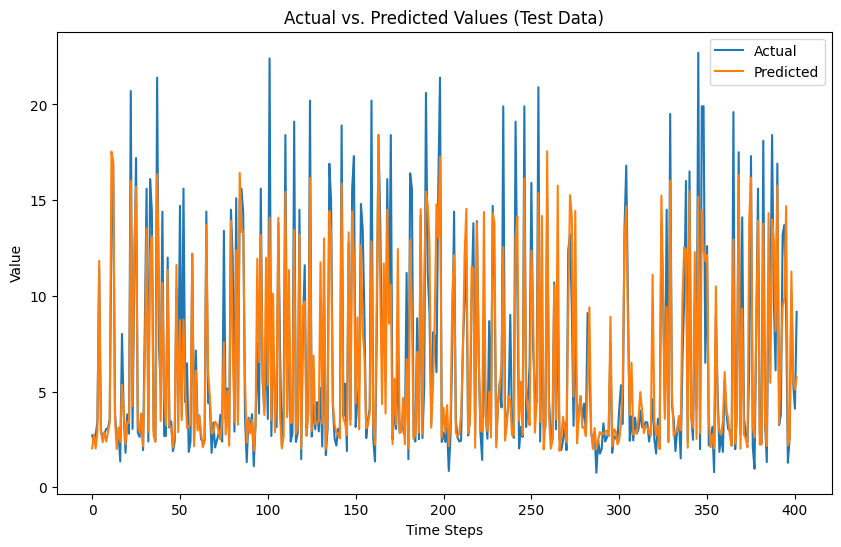

In [92]:
# Get the model's predictions on the test data
y_test_pred = model.predict(X_test)

# Calculate MAE
mae = mean_absolute_error(y_test, y_test_pred)


# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

# Calculate R2
r2 = r2_score(y_test, y_test_pred)

print("MAE:", mae)
print("RMSE:", rmse)
print("R-squared (R2):", r2)

# Plot the actual vs. predicted values from the test set
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_test_pred, label='Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values (Test Data)')
plt.legend()
plt.show()
